In [5]:
import pandas as pd
import numpy as np

# Load weather data and fill in any missing values
weather = pd.read_csv('data/clean_weather.csv', index_col=0)
weather = weather.ffill()

# NN needs to know that there is a correlation between the data, howevever, this is expensive to do with regular NN models since it needs to relearn the relationships within the sequence.
weather["tmax"].head(10).to_numpy()[np.newaxis,:]

array([[60., 52., 52., 53., 52., 50., 52., 56., 54., 57.]])

We can use a recurrent neural network to do this. We take an input sequence and pass it through a recurrent layer. 
This layer will pass the output of the previous time step to the next time step. This allows the network to learn the relationships between the data points in the sequence.
This means that the network can build a memory of the sequence and use it to make predictions.

Recurrent neural networks share its parameters across steps in a sequence. In this case, each element of a sequence serve as different inputs (i.e. different time steps) into the network

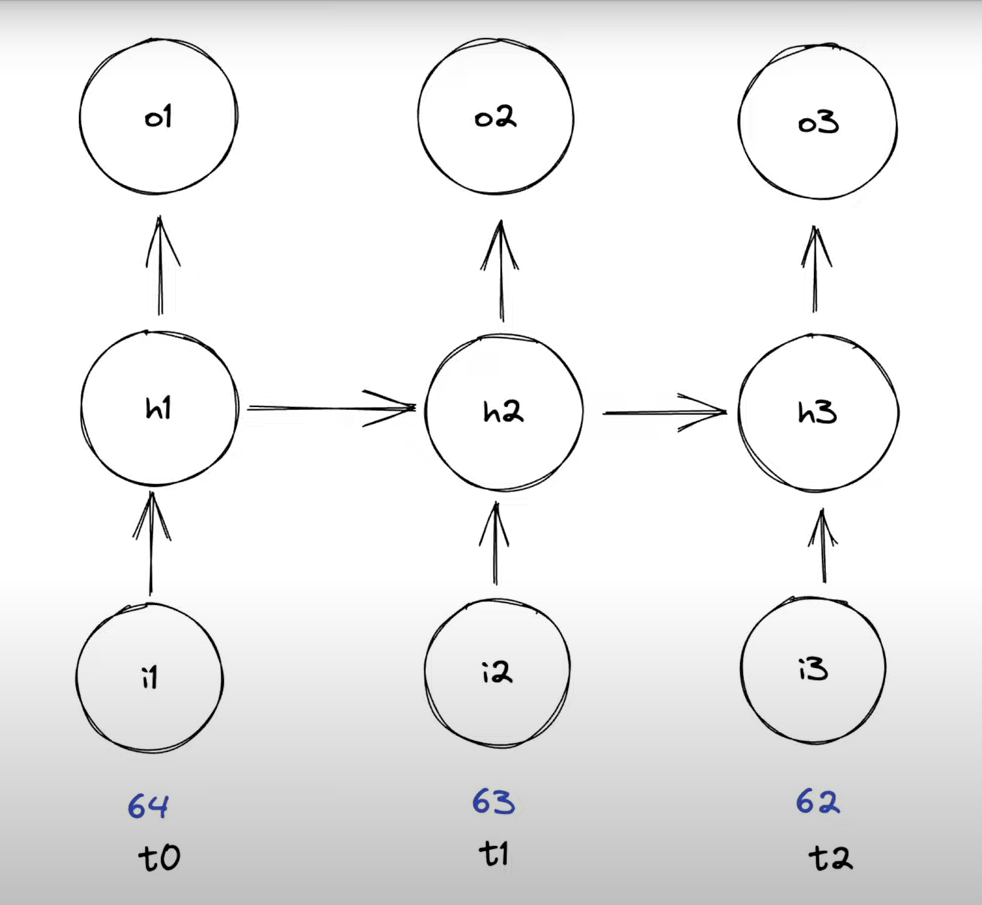

In [6]:
# Forward pass Example
np.random.seed(0)
input_weight = np.random.rand(1,2)
hidden_weight = np.random.rand(2,2) # For RNN's, we also have hidden weights 
output_weight = np.random.rand(2,1)

temps = weather["tmax"].tail(3).to_numpy()
temps

array([66., 70., 62.])

In [7]:
# For example purposes, we will use the last 3 days of temperature data to predict the next day's temperature
x0 = temps[0].reshape(1,1)
x1 = temps[1].reshape(1,1)
x2 = temps[2].reshape(1,1)

xi_0 = x0 @ input_weight
xi_0

array([[36.22169126, 47.20249818]])

In [8]:
xh_0 = np.maximum(0, xi_0) # ReLU activation applied as hidden layer
xh_0 # Prediction for first sequence element

array([[36.22169126, 47.20249818]])

In [9]:
# Second sequence element
xi_1 = x1 @ input_weight
xh = xh_0 @ hidden_weight
xh_1 = np.maximum(0, xi_1 + xh) # ReLU activation applied as hidden layer. Note that the hidden layer from the previous sequence element is added to the input of the current sequence element
xh_1 # Prediction for second sequence element

array([[ 80.24761908, 100.28766177]])

In [10]:
xo_1 = xh_1 @ output_weight
xo_1

array([[124.54916092]])

In [11]:
# Third sequence element
xi_2 = x2 @ input_weight
xh = xh_1 @ hidden_weight
xh_2 = np.maximum(0, xi_2 + xh)
xo_2 = xh_2 @ output_weight
xo_2

array([[190.94853131]])

Note that our predictions for the next element in the sequence keeps getting higher. This is because of the ReLu activation function, as it doesn't scale the output. This is why we'll use the tanh function to scale the results. Tanh also has a good gradient (inexpensive)

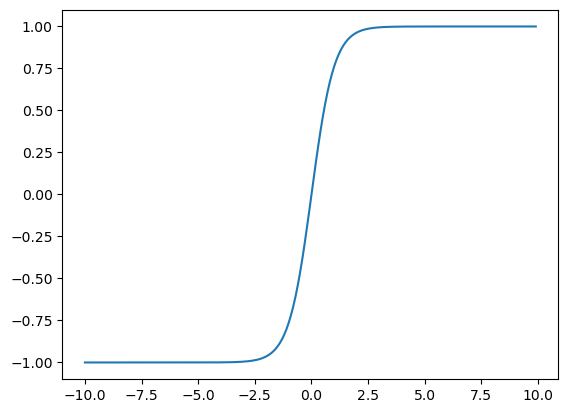

In [12]:
# Tanh activation function
import matplotlib.pyplot as plt
temps = np.arange(-10, 10, 0.1)
y = np.tanh(temps)
plt.plot(temps, y)

In [13]:
from sympy import symbols, diff, exp
x = symbols('x')
sympy_tanh = (exp(x) - exp(-x)) / (exp(x) + exp(-x))
diff(sympy_tanh, x) # Derivative of tanh function which is also 1 - tanh^2(x)

(-exp(x) + exp(-x))*(exp(x) - exp(-x))/(exp(x) + exp(-x))**2 + 1

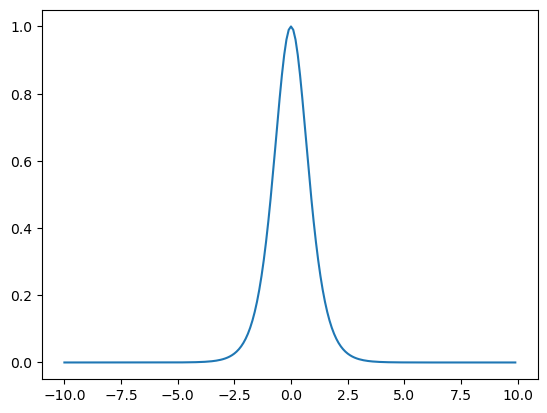

In [14]:
plt.plot(temps, 1-np.tanh(temps)**2) # Allows us to not get stuck in gradient descent

In [15]:
# Full forward pass
np.random.seed(0)

input_weight = np.random.rand(1,5) / 5 - 0.1 # Random weights between -0.1 and 0.1
hidden_weight = np.random.rand(5,5) / 5 - 0.1
hidden_bias = np.random.rand(1,5) / 5 - 0.1

o_weights = np.random.rand(5,1)*50
o_bias = np.random.rand(1,1)

outputs = np.zeros(3)
hiddens = np.zeros((3,5))
prev_hidden = None # For the first sequence element, there is no previous hidden layer
sequence = weather["tmax"].tail(3).to_numpy()

for i in range(3):
    x = sequence[i].reshape(1,1) # Take the current sequence element
    xi = x @ input_weight
    if prev_hidden is None:
        xh = xi
    else:
        xh = xi + prev_hidden @ hidden_weight + hidden_bias
    xh = np.tanh(xh) # Apply tanh activation function

    # Update step
    prev_hidden = xh
    hiddens[i,] = xh # Store hidden layer for backpropagation later
    xo = xh @ o_weights + o_bias
    outputs[i] = xo

hiddens # Notice how hiddens are not growing crazy large

array([[ 0.56784618,  0.99320288,  0.87557333,  0.53166114, -0.76483255],
       [ 0.58366756,  0.99568651,  0.90034879,  0.69338529, -0.84149203],
       [ 0.5383306 ,  0.99164251,  0.86287584,  0.66091071, -0.80543591]])

In [38]:
# Loss function
def mse(actual, predicted):
    return np.mean((actual - predicted)**2)
    
def mse_gradient(actual, predicted):
    return predicted-actual

In [17]:
actuals = np.array([70, 62, 65])
loss_grad = mse_gradient(actuals, outputs)
loss_grad

array([ 4.31470595, 18.66149404, 12.67852446])

Now we need to backpropagate the loss gradient through the network. However, this is more challenging than regular NNs becuase the 
hidden layers output to their output AS WELL as the next hidden layer's output

In [22]:
# Backpropagation - loop backwards from last sequence element to first
next_hidden = None
o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0]*5

for i in range(2, -1, -1):
    l_grad = loss_grad[i].reshape(1,1)

    # Adjust output weights
    o_weight_grad += hiddens[i] [:,np.newaxis] @ l_grad # dL/dW = dy/dW * dL/dy -> y = hiddens * hidden_weights + hidden_bias so dy/dW = hiddens
    o_bias_grad += np.mean(l_grad)
    o_grad = l_grad @ o_weights.T # Passing the gradient back to the previous hidden layer

    if next_hidden is None:
        h_grad = o_grad
    else:
        h_grad = o_grad + next_hidden @ hidden_weight.T
    
    # Undo tanh activation
    tanh_deriv = 1 - hiddens[i,:] [np.newaxis,:] # np.newaxis is used to make the dimensions match (transpose)
    h_grad = np.multiply(h_grad, tanh_deriv)

    next_hidden = h_grad

    if i > 0:
        h_weight_grad += hiddens[i-1,:] [:,np.newaxis] @ h_grad
        h_bias_grad += np.mean(h_grad)
    
    i_weight_grad += sequence[i].reshape(1,1).T @ h_grad

In [23]:
i_weight_grad # Gradients wrt sequence parameters

array([[ 32352.67091083,    392.99655233,   9528.43418739,
         35514.29142052, 146401.10347147]])

In [24]:
# Update parameters using learning rate
lr = 1e-6
input_weight -= i_weight_grad * lr
hidden_weight -= h_weight_grad * lr
hidden_bias -= h_bias_grad * lr
o_weights -= o_weight_grad * lr
o_bias -= o_bias_grad * lr

input_weight

array([[-0.02258997,  0.04264488,  0.01102424, -0.02653765, -0.16167014]])

In [25]:
# Let's do a full implementation now

from sklearn.preprocessing import StandardScaler
import math

PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Scale data to have mean 0 and variance 1
scaler = StandardScaler()
weather[PREDICTORS] = scaler.fit_transform(weather[PREDICTORS])

# Split into training, validation and test sets
np.random.seed(0)
split_data = np.split(weather, [int(0.7*len(weather)), int(0.85*len(weather))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[df[PREDICTORS].to_numpy(), df[[TARGET]].to_numpy()] for df in split_data]

In [31]:
def init_params(layer_conf):
    # layer conf is a list of dictionaries
    layers = []
    for i in range(1, len(layer_conf)):
        np.random.seed(0)
        k = 1/math.sqrt(layer_conf[i]["hidden"])
        i_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"]) * 2 * k - k
        h_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["hidden"]) * 2 * k - k
        h_bias = np.random.rand(1, layer_conf[i]["hidden"]) * 2 * k - k

        o_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["output"]) * 2 * k - k
        o_bias = np.random.rand(1, layer_conf[i]["output"]) * 2 * k - k

        layers.append([i_weight, h_weight, h_bias, o_weight, o_bias])
    return layers

In [27]:
layer_conf = [{"type": "input", "units": 3}, {"type": "rnn", "hidden": 4, "output": 1}] # Each layer is its own dictionary

In [28]:
def forward(x, layers):
    hiddens = []
    outputs = []
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = np.zeros((x.shape[0], i_weight.shape[1]))
        output = np.zeros((x.shape[0], o_weight.shape[1]))
        for j in range(x.shape[0]):
            input_x = x[j,:] [np.newaxis,:] @ i_weight
            hidden_x = input_x + hidden[max(j-1,0),:] [np.newaxis,:] @ h_weight + h_bias
            hidden_x = np.tanh(hidden_x)
            # Store hidden for use in backpropagation
            hidden[j,:] = hidden_x

            # Output layer for calculating loss and backpropagation
            output_x = hidden_x @ o_weight + o_bias
            output[j,:] = output_x
        hiddens.append(hidden)
        outputs.append(output)
    return hiddens, outputs[-1]

In [33]:
def backward(layers, x, lr, grad, hiddens):
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = hiddens[i]
        next_h_grad = None
        o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0]*5

        for j in range(x.shape[0]-1, -1, -1):
            # Add newaxis in first dimension to match the dimensions of the hidden layer
            out_grad = grad[j,:][np.newaxis,:]

            # Output updates - np.newaxis creates a size 1 axis, in this case transposing matrix
            o_weight_grad += hidden[j,:] [:,np.newaxis] @ out_grad
            o_bias_grad += np.mean(out_grad)

            # Backpropagate gradient to hidden layer
            h_grad = out_grad @ o_weight.T

            if j < x.shape[0]-1: # If not at last sequence element
                # Multiply the gradient by the hidden weights to pull the gradient from the next hidden state to the current hidden state
                hh_grad = next_h_grad @ h_weight.T
                # Add the gradients together to combine output contribution and hidden contribution
                h_grad += hh_grad
            
            # Undo tanh activation - pull value across non-linearity
            tanh_deriv = 1 - hidden[j,:] [np.newaxis,:]**2
            h_grad = np.multiply(h_grad, tanh_deriv)

            # Store to compute hidden layer gradients for previous sequence element
            next_h_grad = h_grad.copy()

            # If we are not at the first sequence element
            if j > 0:
                # Multiply input from previous layer by post-non-linearity gradient at current layer to propogate gradient
                h_weight_grad += hidden[j-1] [:,np.newaxis] @ h_grad
                h_bias_grad += np.mean(h_grad)
            
        # Normalize lr by number of sequence elements
        lr /= x.shape[0]
        i_weight -= i_weight_grad * lr
        h_weight -= h_weight_grad * lr
        h_bias -= h_bias_grad * lr
        o_weight -= o_weight_grad * lr
        o_bias -= o_bias_grad * lr
        layers[i] = [i_weight, h_weight, h_bias, o_weight, o_bias]
        
    return layers

In [44]:
epochs = 250
lr = 1e-4

layers = init_params(layer_conf)
for epoch in range(epochs):
    sequence_len = 7
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        seq_x = train_x[j:j+sequence_len]
        seq_y = train_y[j:j+sequence_len]

        hiddens, outputs = forward(seq_x, layers)
        grad = mse_gradient(seq_y, outputs)
        params = backward(layers, seq_x, lr, grad, hiddens)
        epoch_loss += mse(seq_y, outputs)

    if epoch % 50 == 0:
        valid_loss = 0
        # Loop through validation set every 50 epochs
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:j+sequence_len]
            seq_y = valid_y[j:j+sequence_len]

            hiddens, outputs = forward(seq_x, layers)
            valid_loss += mse(seq_y, outputs)
        print(f"Epoch {epoch} - Training Loss: {epoch_loss/len(train_x)}, Validation Loss: {valid_loss/len(valid_x)}")

Epoch 0 - Training Loss: 704.5663274969316, Validation Loss: 141.4089996415935
Epoch 50 - Training Loss: 42.56902666733432, Validation Loss: 50.49567322194452
Epoch 100 - Training Loss: 38.858522660449864, Validation Loss: 43.8771045686354
Epoch 150 - Training Loss: 38.3705947198066, Validation Loss: 43.103550011952954
Epoch 200 - Training Loss: 38.179915287404, Validation Loss: 42.81716181420354
